In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch, LinearStretch
from photutils.detection import find_peaks
import argparse
import os


$\frac{S}{N} \cong \frac{N_*}{\sqrt{N_*+n_{p i x}\left(1+\frac{n_{p i x}}{n_B}\right)\left(N_S+N_D+N_R^2+G^2 \sigma_f^2\right)}}$

N* = signal

$n_{pix}$ = sum of pixels in mask/aperture [pixels $^2$]

$\frac{n_{p i x}}{n_B}$ = negligible? 

$N_S$ = sky pixels (negligible)

$N_D$ = number of dark current electrons per pixel [$e^-$]

$N_R$ = number of electrons per pixel from read noise [$e^-$/pixel]

$G^2 \sigma_f^2$ = gain * constant, negl. for low gain

So ?

$N = \sqrt{N_*+n_{p i x}(N_D +N_R^2)}$

https://diffractionlimited.com/wp-content/uploads/2018/06/AAS_STF.pdf

Instrument Gain 0.37e-/ADU 

Read Noise ~9.3e-

In [2]:
from psf_photometry_mplw import get_frame_info

In [3]:
path = '/Users/bencapistrant/Documents/GitHub/rho_data_reduction_pipeline/data/WASP36b/Reduced/'

In [189]:
pd.read_csv(path+'Uncertainties.csv',sep='\s+')

,Read_Noise,42.59765251748035
0,Dark_Current_0.4s,3398.505869
1,Dark_Current_150.0s,9.886016
2,Flat_R_Noise,0.053058


In [190]:
uncert_df = pd.read_csv(path+'Uncertainties.csv',delim_whitespace=True,header =None)
uncert_df

,0,1
0,Read_Noise,42.597653
1,Dark_Current_0.4s,3398.505869
2,Dark_Current_150.0s,9.886016
3,Flat_R_Noise,0.053058


In [142]:
dark_current_150s = uncert_df.loc[uncert_df[0] == 'Dark_Current_150.0s', 1].values[0]
dark_current_150s

9.886015649883465

In [ ]:
# New get_frame_info function to include dark current and read noise - added to psf_photometry_mplw_v2.py

def get_frame_info(directories):
    """
    Extracts information from FITS file headers for reduced frames.
    """
    directories_list, file_list = [], []
    objects, dates, filters, exposure_times,dark_currents,read_noise = [], [], [], [], [], []
    
    # Iterate through all directories
    for directory in directories:
        head_dir  = os.path.dirname(os.path.abspath(directory)) + '/' #Want to get dark current from uncertainties.csv in parent directory 
        
        # Get all FITS files in the directory
        fits_files = [f for f in os.listdir(directory) if f.endswith('.fits')]
        uncert = pd.read_csv(head_dir + 'Uncertainties.csv', header=None, delim_whitespace=True)
        for file in fits_files:
            try:
                # Read the FITS header
                header = fits.getheader(os.path.join(directory, file))

                # Extract relevant header information
                directories_list.append(directory)
                file_list.append(file)
                objects.append(header.get('OBJECT', 'Unknown'))
                dates.append(header.get('DATE-OBS', 'Unknown'))
                filters.append(header.get('FILTER', 'Unknown'))
                exp = header.get('EXPTIME', 'Unknown')
                exposure_times.append(exp)
                dark_currents.append(uncert.loc[uncert[0] == f'Dark_Current_{exp}s', 1].values[0])
                read_noise = uncert.loc[uncert[0] == 'Read_Noise', 1].values[0]
            except Exception as e:
                print(f"Error processing file {file} in {directory}: {e}")
                continue
        
        
    
        
    # Create a DataFrame with the extracted information
    reduced_frame_info = pd.DataFrame({'Directory': directories_list,
                                       'File': file_list,
                                       'Object': objects,
                                       'Date-Obs': dates,
                                       'Filter': filters,
                                       'Exptime': exposure_times,
                                       'Dark Current': dark_currents,
                                        'Read Noise': read_noise
                                       })

    return reduced_frame_info

In [169]:
frame = get_frame_info([path+'WASP-36B/'])

In [170]:
frame

,Directory,File,Object,Date-Obs,Filter,Exptime,Dark Current,Read Noise
0,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0132_reduced.fits,WASP-36B,2025-02-18T01:44:30.345,R,150.0,9.886016,42.597653
1,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0167_reduced.fits,WASP-36B,2025-02-18T03:15:50.730,R,150.0,9.886016,42.597653
2,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0135_reduced.fits,WASP-36B,2025-02-18T01:52:14.432,R,150.0,9.886016,42.597653
3,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0160_reduced.fits,WASP-36B,2025-02-18T02:57:57.963,R,150.0,9.886016,42.597653
4,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0175_reduced.fits,WASP-36B,2025-02-18T03:36:17.242,R,150.0,9.886016,42.597653
...,...,...,...,...,...,...,...,...
59,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0188_reduced.fits,WASP-36B,2025-02-18T04:09:30.453,R,150.0,9.886016,42.597653
60,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0141_reduced.fits,WASP-36B,2025-02-18T02:07:33.394,R,150.0,9.886016,42.597653
61,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0146_reduced.fits,WASP-36B,2025-02-18T02:21:08.186,R,150.0,9.886016,42.597653
62,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0153_reduced.fits,WASP-36B,2025-02-18T02:39:07.041,R,150.0,9.886016,42.597653


In [7]:
def perform_psf_photometry(self, x, y, width, height):
        """
          Perform PSF photometry on the selected region.
          """
        # Create a dataframe to store the results
        df = pd.DataFrame(columns=['File', 'Object', 'Exptime', 'Filter', 'Star', 'X', 'Y', 'Flux', 'Error'])
        
        # Fill in the file, object, exptime, and filter information
        df['File'] = [self.frame_info['File'][self.current_index]]
        df['Object'] = [self.frame_info['Object'][self.current_index]]
        df['Exptime'] = [self.frame_info['Exptime'][self.current_index]]
        df['Filter'] = [self.frame_info['Filter'][self.current_index]]
        
        # Extract the selected region
        sub_image = self.image_data[y:y+height, x:x+width]
        
        # Perform PSF photometry on the selected region
        mean, median, std = sigma_clipped_stats(sub_image, sigma=3.0, maxiters=5)
        
        # Find the peaks in the selected region
        peaks_tbl = find_peaks(sub_image, mean + 5 * std, box_size=5).to_pandas().sort_values(by='peak_value', ascending=False).reset_index(drop=True)
        
        # Create a cutout region of the star
        star_cutout = sub_image[int(peaks_tbl['y_peak'].iloc[0]) - height:int(peaks_tbl['y_peak'].iloc[0]) + height,
                                int(peaks_tbl['x_peak'].iloc[0]) - width:int(peaks_tbl['x_peak'].iloc[0]) + width]
        
        # Calculate stats for the star cutout
        star_mean, star_median, star_std = sigma_clipped_stats(star_cutout, sigma=3.0, maxiters=5)
        
        # Calculate the flux and error
        flux = star_cutout[star_cutout > 3.*star_std].sum()
        flux_err = np.sqrt(flux)
        
        # Fill in the PSF photometry results
        df['Star'] = [1]
        df['x_peak'] = [x + peaks_tbl['x_peak'].iloc[0]]
        df['y_peak'] = [y + peaks_tbl['y_peak'].iloc[0]]
        df['Flux'] = [flux]
        df['Error'] = [flux_err]
        
        # Store the dataframe in the dictionary
        self.psf_results[self.current_index] = df
        
        # Display PSF information on the image
        self.display_psf(x, y, width, height)

In [187]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip

def calc_background(image):

    """
    Subtracts the background from an astronomical image using a 2D background estimation.

    This function estimates the sky background of the input image by assuming a non-uniform
    background brightness. The background is modeled using a sigma-clipped median estimator, 
    and sources are masked out before computing the background. The estimated background is 
    then subtracted from the input image to produce a background-subtracted image.

    Args:
        image (numpy.ndarray): 2D array representing the astronomical image from which the 
                               background will be subtracted.

    Returns:
        numpy.ndarray: The background-subtracted image.
    """
    # Define the paameters to estimate the the sky background of the image
    # A non-uniform background brightness is going to be assumed
        # try:
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(image, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(image, threshold, npixels=10)
    footprint = circular_footprint(radius=10)
    mask = segment_img.make_source_mask(footprint=footprint)
    box_size = (30, 30)
    filter_size = (3, 3)
    bkg_estimator = MedianBackground()
    
    # Estimate the 2D background of the image
    bkg = Background2D(image, box_size=box_size, mask=mask, filter_size=filter_size, 
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

    # Subtract the background from the image reduced image
    

    
        
    return np.nanmedian(bkg.background)

In [188]:
calc_background(cal_image)

0.04954329464000978

In [ ]:
(sum_flux*gain)/exp

to magnitude 2.5

In [12]:
from stellarphot.photometry import aperture_photometry
# from stellarphot import settings

In [13]:
import stellarphot

In [14]:
raw = pd.read_csv(path+'psf_photometry_results.csv')
raw

,File,Star_1_x,Star_1_y,Star_1_flux,Star_2_x,Star_2_y,Star_2_flux,Star_3_x,Star_3_y,Star_3_flux,Star_4_x,Star_4_y,Star_4_flux,Star_5_x,Star_5_y,Star_5_flux
0,WASP36B.2025-02-17.0132_reduced.fits,543,406,670671.358690,683,441,121267.877826,555,570,29783.487838,621,527,34124.386831,642,566,87522.887406
1,WASP36B.2025-02-17.0167_reduced.fits,543,406,693278.398982,683,441,131043.238527,555,570,32416.558423,621,527,35949.038465,642,566,106914.560950
2,WASP36B.2025-02-17.0135_reduced.fits,543,406,741113.374284,683,441,135535.775694,555,570,33612.780117,621,527,36651.649470,642,566,109577.763584
3,WASP36B.2025-02-17.0160_reduced.fits,543,406,631126.804051,683,441,114118.345224,555,570,25731.796325,621,527,30163.020544,642,566,93302.232791
4,WASP36B.2025-02-17.0175_reduced.fits,543,406,654660.191481,683,441,117292.412140,555,570,27304.441169,621,527,30023.078442,642,566,92043.622515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,WASP36B.2025-02-17.0188_reduced.fits,543,406,619044.909323,683,441,109227.982173,555,570,23502.988423,621,527,24513.946442,642,566,90965.324089
60,WASP36B.2025-02-17.0141_reduced.fits,543,406,226252.331096,683,441,40949.914843,555,570,662.776139,621,527,2597.814933,642,566,30308.543344
61,WASP36B.2025-02-17.0146_reduced.fits,543,406,673934.653581,683,441,121705.843614,555,570,27629.257950,621,527,30173.110795,642,566,100050.509921
62,WASP36B.2025-02-17.0153_reduced.fits,543,406,681688.032157,683,441,126831.808968,555,570,34817.995679,621,527,34295.696722,642,566,100899.452104


In [ ]:
/Users/bencapistrant/Documents/GitHub/rho_data_reduction_pipeline/data/WASP36b/Reduced/WASP-36B/WASP36B.2025-02-17.0130_reduced.fits

In [15]:
fits.getdata(path+'WASP-36B/'+raw['File'][0])

array([[  7.96902535,   7.96902535,   7.96902535, ...,   7.96902535,
          7.96902535,   7.96902535],
       [  7.96902535,   7.96902535,   7.96902535, ...,   7.96902535,
          7.96902535,   7.96902535],
       [  7.96902535,   7.96902535,   7.96902535, ...,   8.03291646,
          8.10716194,   7.72857368],
       ...,
       [  7.96902535,   7.96902535,   7.96902535, ..., 103.64580697,
        240.54900408, 157.8162414 ],
       [  7.96902535,   7.96902535,   7.96902535, ..., 251.34185851,
        181.01723752,  47.1964211 ],
       [  7.96902535,   7.96902535,   7.96902535, ..., 278.45694607,
        193.55176531, 157.03789911]])

In [16]:
obs_info = pd.read_csv(path+'frame_info.csv')
obs_info

,Directory,File,Object,Date-Obs,Filter,Exptime
0,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0132_reduced.fits,WASP-36B,2025-02-18T01:44:30.345,R,150.0
1,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0167_reduced.fits,WASP-36B,2025-02-18T03:15:50.730,R,150.0
2,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0135_reduced.fits,WASP-36B,2025-02-18T01:52:14.432,R,150.0
3,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0160_reduced.fits,WASP-36B,2025-02-18T02:57:57.963,R,150.0
4,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0175_reduced.fits,WASP-36B,2025-02-18T03:36:17.242,R,150.0
...,...,...,...,...,...,...
59,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0188_reduced.fits,WASP-36B,2025-02-18T04:09:30.453,R,150.0
60,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0141_reduced.fits,WASP-36B,2025-02-18T02:07:33.394,R,150.0
61,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0146_reduced.fits,WASP-36B,2025-02-18T02:21:08.186,R,150.0
62,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP36B.2025-02-17.0153_reduced.fits,WASP-36B,2025-02-18T02:39:07.041,R,150.0


In [17]:
combined = pd.merge(raw, obs_info, left_on='File', right_on='File', how='left').sort_values(by='Date-Obs').reset_index(drop=True)
combined

,File,Star_1_x,Star_1_y,Star_1_flux,Star_2_x,Star_2_y,Star_2_flux,Star_3_x,Star_3_y,Star_3_flux,...,Star_4_y,Star_4_flux,Star_5_x,Star_5_y,Star_5_flux,Directory,Object,Date-Obs,Filter,Exptime
0,WASP36B.2025-02-17.0130_reduced.fits,543,406,727361.701423,683,441,131711.510206,555,570,35987.712223,...,527,37072.415798,642,566,105163.566977,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T01:39:22.989,R,150.0
1,WASP36B.2025-02-17.0131_reduced.fits,543,406,663961.454132,683,441,118690.397628,555,570,25350.349770,...,527,32207.508229,642,566,93010.369548,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T01:41:56.670,R,150.0
2,WASP36B.2025-02-17.0132_reduced.fits,543,406,670671.358690,683,441,121267.877826,555,570,29783.487838,...,527,34124.386831,642,566,87522.887406,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T01:44:30.345,R,150.0
3,WASP36B.2025-02-17.0133_reduced.fits,543,406,699891.424845,683,441,128013.876762,555,570,31169.002934,...,527,31183.817321,642,566,98418.468434,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T01:47:05.012,R,150.0
4,WASP36B.2025-02-17.0134_reduced.fits,543,406,709269.775553,683,441,127232.737018,555,570,32164.435783,...,527,35110.712910,642,566,105622.539785,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T01:49:38.284,R,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,WASP36B.2025-02-17.0192_reduced.fits,543,406,618764.763839,683,441,109684.419236,555,570,29505.763716,...,527,28452.656358,642,566,88893.180448,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T04:19:44.489,R,150.0
60,WASP36B.2025-02-17.0193_reduced.fits,543,406,635385.294980,683,441,117480.386913,555,570,28102.697351,...,527,30070.196590,642,566,92336.525269,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T04:22:16.948,R,150.0
61,WASP36B.2025-02-17.0194_reduced.fits,543,406,629138.414589,683,441,111887.459954,555,570,28245.419754,...,527,26546.830165,642,566,89747.877828,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T04:24:50.026,R,150.0
62,WASP36B.2025-02-17.0195_reduced.fits,543,406,585111.693677,683,441,100537.156709,555,570,21588.787460,...,527,23353.492408,642,566,83022.476572,/Users/bencapistrant/Documents/GitHub/rho_data...,WASP-36B,2025-02-18T04:27:22.819,R,150.0


In [53]:
dir(stellarphot)

['Camera',
 'LooseVersion',
 'UnsupportedPythonError',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__minimum_python_version__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '__warningregistry__',
 '_astropy_init',
 'add_to_photometry_table',
 'calculate_noise',
 'clipped_sky_per_pix_stats',
 'compute_fwhm',
 'core',
 'faster_sigma_clip_stats',
 'find_times',
 'find_too_close',
 'photometry',
 'photometry_on_directory',
 'photutils_stellar_photometry',
 'source_detection',
 'sys',
 'test',
 'version']

In [19]:
from stellarphot.photometry import extract_stars
from stellarphot import source_detection

In [108]:
sources = source_detection(fits.getdata(path+'WASP-36B/'+raw['File'][0]),threshold=75)
sources

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 237.10983440613384 ... 12.782410548971708   -2.766531905564906
  2  658.5479922477919 ... 1.2292090927957484  -0.2240644104781246
  3  548.5991983646124 ...  3.781753717917668  -1.4442331063333282
  4  208.7483712625423 ...  1.667466591877749  -0.5551428536851264
  5 1015.9678195423746 ...  2.694229705150627  -1.0760865503183787
  6 196.40384228660744 ... 3.9476045092149414  -1.4908340909532374
  7  85.26323587336907 ... 1.5656488427331519  -0.4867359033012377
  8  883.9751409823559 ... 1.8959336654307934  -0.6945578456362667
  9  895.6286089972006 ... 1.3649267229354725 -0.33777334148405896
 10  83.47983731524178 ... 1.6695992332827336  -0.5565305915492882
...                ... ...                ...                  ...
 23  642.1197639784228 ... 1.2286753715319587 -0.22359288261189328
 24  542.2291229238767 ... 15.001700903542238  -2.940351256163

Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!
Still fitting!!


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,FWHM
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
1,237.10983440613384,27.310453807471706,0.4962154018001117,-0.15640342710598196,-0.6885671426075649,121,0.0,27945.338227657136,12.782410548971708,-2.766531905564906,6.350996095400747
2,658.5479922477919,30.841218768974684,0.5532668906152621,-0.09458495557161806,-0.6387379255670774,121,0.0,2833.5518277501114,1.2292090927957484,-0.2240644104781246,2.7680776601369656e-38
3,548.5991983646124,60.264978369540245,0.4920481566487415,-0.04869168931928193,-0.6682660589492248,121,0.0,8236.229128595369,3.781753717917668,-1.4442331063333282,6.47953490687554
4,208.7483712625423,141.0437655834419,0.49701409597553775,-0.17712184689189006,-0.637671594748086,121,0.0,3599.2456292097213,1.667466591877749,-0.5551428536851264,2.7680776601369656e-38
5,1015.9678195423746,175.30125263054657,0.4514170764648967,-0.10100782611940964,-0.7010635591079776,121,0.0,5670.916761994255,2.694229705150627,-1.0760865503183787,0.20846436801939305
6,196.40384228660744,186.31845481563838,0.4050126601584669,-0.0010420933896765486,-0.6313199119880768,121,0.0,9143.854093870817,3.9476045092149414,-1.4908340909532374,7.397281757993149
7,85.26323587336907,209.89378141598021,0.5059840910287108,-0.1342464057416179,-0.6566204381500802,121,0.0,3409.8682734497456,1.5656488427331519,-0.4867359033012377,2.7680776601369656e-38
8,883.9751409823559,217.7632877012611,0.4452343365545545,-0.13225675795381706,-0.7054152635623134,121,0.0,3949.3339606618147,1.8959336654307934,-0.6945578456362667,14.050021478782664
9,895.6286089972006,223.89917587259373,0.5222726435161849,-0.22260234204954588,-0.7061363149890122,121,0.0,3125.906368534409,1.3649267229354725,-0.33777334148405896,14.267348620399964


In [21]:
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.table import Table
from astropy.time import Time

from stellarphot.photometry import *
from stellarphot.source_detection import *
from stellarphot import Camera

from stellarphot.visualization.photometry_widget_functions import PhotometrySettings

In [89]:
cam = Camera(gain=0.37, read_noise=42.59765251748035, dark_current=9.88601564988346)

In [24]:
from pathlib import Path

import numpy as np
import ipywidgets as ipw
from ipyfilechooser import FileChooser

from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.table import Table
from astropy.time import Time

from stellarphot.photometry import *
from stellarphot.source_detection import *
from stellarphot import Camera

from stellarphot.visualization.photometry_widget_functions import PhotometrySettings

In [25]:
from stellarphot import tests

In [27]:
ps = PhotometrySettings()
ps.box

In [30]:
import functools
import re
from pathlib import Path
import requests

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from stellarphot.visualization.comparison_functions import (
    read_file, set_up, mag_scale, in_field, wrap, make_markers,
    
)
from stellarphot.visualization.seeing_profile_functions import set_keybindings

In [31]:
from stellarphot.visualization.comparison_functions import ComparisonViewer
from stellarphot.visualization.fits_opener import FitsOpener

In [32]:
path

'/Users/bencapistrant/Documents/GitHub/rho_data_reduction_pipeline/data/WASP36b/Reduced/'

In [33]:
bright_mag_limit = 9
dim_mag_limit = 16
Cmag = 12.7

# 👉 File to save apertures in
aperture_output_file = path+'aperture_locations.csv'

# 👉 File to exoplanet info in
# tess_info_output_file = 'tess-info.pickle' 

In [98]:
# comp_viewer = ComparisonViewer(
#                            target_mag=Cmag,
#                            bright_mag_limit=bright_mag_limit,
#                            dim_mag_limit=dim_mag_limit,
#                            targets_from_file=None,
#                            aperture_output_file=aperture_output_file,
                           
#                         #    fits_opener=fo,
#                           )
# comp_viewer.box

In [79]:
from astropy.wcs import WCS
from astropy import wcs
fits_file = path + 'WASP-36B/WASP36B.2025-02-17.0130_reduced.fits'
index_choice = 0
with fits.open(fits_file, mode="readonly") as hdulist:
    wcs_info = WCS(hdulist[index_choice].header)
    cal_image = hdulist[index_choice].data
    header = hdulist[index_choice].header

In [111]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1117                                                  
NAXIS2  =                  844                                                  
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'SBIG CCD'           / Camera Name                                    
TELESCOP= 'Telescope Simulator' / Telescope name                                
EXPTIME =         1.500000E+02 / Total Exposure Time (s)                        
CCD-TEMP=            1.890E-01 / CCD Temperature (Celsius)                      
PIXSIZE1=         5.400000E+00 / Pixel Size 1 (microns)                         
PIXSIZE2=         5.400000E+00 / Pixel Size 2 (microns)                         
XBINNING=                   

In [70]:
# Header info
ra_str = '08:47:34.31'
dec_str = '-08:07:13.3'
centrdx = 1006.95
centrdy = 658.01
pixel_scale = 0.94  # arcsec/pixel from 14-inch Meade + 16.2 µm binned pixels

# Parse sky coordinates
ra_dec = SkyCoord(ra_str, dec_str, unit=(u.hour, u.deg))

# Build WCS object
wcs = WCS(naxis=2)
wcs.wcs.crpix = [centrdx, centrdy]
wcs.wcs.crval = [ra_dec.ra.deg, ra_dec.dec.deg]
wcs.wcs.cdelt = [-pixel_scale / 3600, pixel_scale / 3600]  # arcsec to degrees
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]


In [55]:
from stellarphot.differential_photometry import catalog_search

In [81]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,FWHM
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
1,915.0364066536223,24.80164455827181,0.7407381351062878,-0.2602322892274782,-0.569930651319049,121,0.0,505.13640587748273,1.4014693538612246,-0.36645901354529214,2.7680776601369656e-38
2,237.10983440613384,27.310453807471706,0.4962154018001117,-0.15640342710598196,-0.6885671426075649,121,0.0,27945.338227657136,95.86807911728782,-4.954185064044156,6.350996095400747
3,658.5479922477919,30.841218768974684,0.5532668906152621,-0.09458495557161806,-0.6387379255670774,121,0.0,2833.5518277501114,9.219068195968113,-2.411717568957375,2.7680776601369656e-38
4,602.0185823545561,31.814033551783105,0.3825956476708315,-0.19221261119326385,-0.7691961962084651,121,0.0,1265.0611888507137,5.0793279974919106,-1.7645156457264675,2.7680776601369656e-38
5,544.1693364735634,39.439769583385285,0.4277855955538156,-0.1747481744553973,-0.7557304810059685,121,0.0,506.6868237641436,1.9262357106721648,-0.7117735750666799,6.7973116813486705
6,722.5748688673186,44.589152833874,0.6087615868584214,0.15843957177333073,-0.5563606972093238,121,0.0,387.39542817879925,1.1941239514919009,-0.19262352354739415,2.7680776601369656e-38
7,901.4491031198572,54.73794662407875,0.5269938835899933,-0.23605941349138607,-0.5926650307338289,121,0.0,885.3800218742355,3.0269358671214452,-1.2025080487159086,2.7680776601369656e-38
8,548.5991983646124,60.264978369540245,0.4920481566487415,-0.04869168931928193,-0.6682660589492248,121,0.0,8236.229128595369,28.36315288438251,-3.6318862648125783,6.47953490687554
9,121.3092202772249,84.86339476022096,0.43467939463866295,-0.24962313504876948,-0.6421571233904354,121,0.0,471.1157836271762,1.7350825141437436,-0.5983003326662119,2.7680776601369656e-38


In [103]:
from matplotlib.patches import Circle

In [109]:
phottab = photutils_stellar_photometry(cal_image,sources,aperture_radius = 10,inner_annulus=15, outer_annulus=20,gain =cam.gain,N_R =cam.read_noise,N_dark_pp=cam.dark_current)
phottab

id,xcenter,ycenter,aperture_sum,background_per_pixel,net_flux,aperture_radius,inner_radius,outer_radius,aperture_sum_err
,pix,pix,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,237.10983440613384,27.310453807471706,1228696.052791332,9.854234534029409,1225600.2537094462,10.0,15.0,20.0,1163.1370328256364
2,658.5479922477919,30.841218768974684,118057.55412014449,-6.719309995055889,120168.48761191049,10.0,15.0,20.0,969.9745669821597
3,548.5991983646124,60.264978369540245,375927.1227973283,8.7597446923385,373175.167840051,10.0,15.0,20.0,1018.4746214612243
4,208.7483712625423,141.0437655834419,157939.5361320087,-1.3351207123239688,158358.97667415795,10.0,15.0,20.0,977.7344342276879
5,1015.9678195423746,175.30125263054657,267685.1141159088,5.661352093157723,265906.54790138383,10.0,15.0,20.0,998.5165041986706
6,196.40384228660744,186.31845481563838,576457.2493537036,2.805149808574883,575575.9855506198,10.0,15.0,20.0,1054.0831010068075
7,85.26323587336907,209.89378141598021,148345.99377467117,9.697145551664049,145299.5456520813,10.0,15.0,20.0,976.2928869409212
8,883.9751409823559,217.7632877012611,205044.86426386915,13.725118962200842,200732.99097373954,10.0,15.0,20.0,987.1139398305872


Calculates photometric noise 

\begin{equation}
\sigma = \sqrt{G \cdot F + A \cdot \left(1 + \frac{A}{B}\right)\cdot \left[ G\cdot S + D \cdot t + R^2 + (0.289 G)^2\right]}
\end{equation}

 where $\sigma$ is the noise, $G$ is the gain, $F$ is the flux,
    $A$ is the aperture area in pixels, $B$ is the annulus area in pixels,
    $S$ is the sky per pixel, $D$ is the dark current per second,
    $R$ is the read noise, and $t$ is exposure time.
    te: The $(0.289 G)^2$ term is "digitization noise" and is optional.

In [124]:
# Find the star in phottab with xcenter, ycenter closest to the center of cal_image
center_x = cal_image.shape[1] / 2
center_y = cal_image.shape[0] / 2

distances = np.sqrt((phottab['xcenter'].value - center_x)**2 + (phottab['ycenter'].value - center_y)**2)
closest_idx = np.argmin(distances)
closest_star = phottab[closest_idx]
closest_star

id,xcenter,ycenter,aperture_sum,background_per_pixel,net_flux,aperture_radius,inner_radius,outer_radius,aperture_sum_err
,pix,pix,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20,543.9071823569888,406.241311324359,828274.4362228352,12.487754599144917,824351.2924119846,10.0,15.0,20.0,1097.6824145964104


In [131]:
print(phottab['xcenter'][19].value, phottab['ycenter'][19].value)

543.9071823569888 406.241311324359


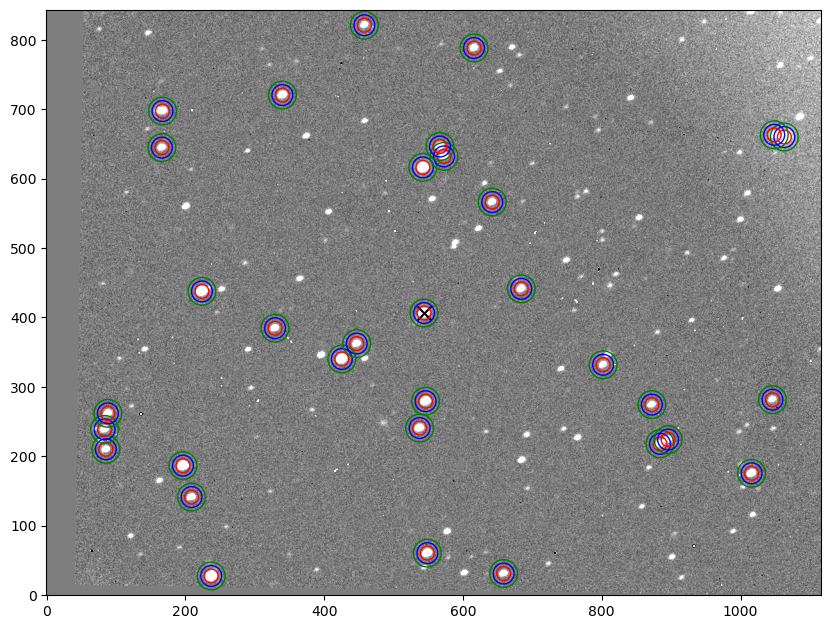

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cal_image, origin='lower', cmap='gray', norm=ImageNormalize(cal_image, interval=ZScaleInterval(),))
# plt.scatter(phottab['xcenter'],sources['ycenter'], s=100, edgecolor='red', facecolor='none', label='Detected Sources')
# target = Circle((phottab['xcenter'][20].value, phottab['ycenter'][20].value),radius=10, edgecolor='black', facecolor='none', linewidth=2, label='Target Source')
# ax.add_patch(target)
plt.scatter(phottab['xcenter'][19].value, phottab['ycenter'][19].value, marker='x',s=100, color='k', label='Target Source')
for i in range(len(phottab)):
    circle = Circle((phottab['xcenter'][i].value, phottab['ycenter'][i].value), radius=10, edgecolor='red', facecolor='none', linewidth=1)
    circle2 = Circle((phottab['xcenter'][i].value, phottab['ycenter'][i].value), radius=15, edgecolor='blue', facecolor='none', linewidth=1)
    circle3 = Circle((phottab['xcenter'][i].value, phottab['ycenter'][i].value), radius=20, edgecolor='green', facecolor='none', linewidth=1)
    ax.add_patch(circle)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
plt.show()

In [137]:
img_y, img_x = np.mgrid[:cal_image.shape[0], :cal_image.shape[1]]
points = np.column_stack((img_x.ravel(), img_y.ravel()))
mask = circle.contains_points(points).reshape(cal_image.shape)
print(mask.shape)

(844, 1117)


In [139]:
num_pixels_in_mask = np.sum(mask)
print(f"Number of pixels in mask: {num_pixels_in_mask}")

Number of pixels in mask: 174


In [138]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [68]:
wcs.wcs_world2pix(ra_dec.ra.deg, ra_dec.dec.deg, 0)

[array(1005.95), array(657.01)]

In [37]:
import functools
import re
from pathlib import Path
import requests

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from stellarphot.visualization.comparison_functions import (
    read_file, set_up, mag_scale, in_field, wrap, make_markers,
)
from stellarphot.visualization.seeing_profile_functions import set_keybindings

In [41]:
# CCDData.read(path+'WASP-36B/WASP36B.2025-02-17.0131_reduced.fits')

In [62]:
fits.getheader(path+'WASP-36B/'+raw['File'][0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1117                                                  
NAXIS2  =                  844                                                  
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'SBIG CCD'           / Camera Name                                    
TELESCOP= 'Telescope Simulator' / Telescope name                                
EXPTIME =         1.500000E+02 / Total Exposure Time (s)                        
CCD-TEMP=            1.890E-01 / CCD Temperature (Celsius)                      
PIXSIZE1=         5.400000E+00 / Pixel Size 1 (microns)                         
PIXSIZE2=         5.400000E+00 / Pixel Size 2 (microns)                         
XBINNING=                   